In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

***
## Global analysis

In [2]:
summary = pd.read_csv('../data/lifespan_summary.csv')
display(summary.head())

,Filename,TimeInfoMergedVideo,PlateHasDried,LifespanInFrames,LifespanInHours,Terbinafine
0,/20240924_piworm09_1,2.45,False,49500,330,True
1,/20240924_piworm09_2,3.30,False,63000,420,True
2,/20240924_piworm09_3,3.12,False,57600,384,True
3,/20240924_piworm09_4,2.48,True,50400,336,True
4,/20240924_piworm09_5,2.43,True,48900,326,True


In [3]:
import re

def _fix_filepath_row(row):
    """
    Complicated for nothing but works
    """
    filename = row['Filename']
    terb = row['Terbinafine']
    m = re.match(r'^/(\d{8})_piworm(\d+)_(\d+)$', filename)
    if m:
        date, worm, idx = m.groups()
    else:
        m2 = re.search(r'coordinates_highestspeed_(\d{8})_(\d+)_(\d+)_with_time_speed', filename)
        if m2:
            date, worm, idx = m2.groups()
        else:
            return filename
    prefix = "TERBINAFINE+" if terb else "TERBINAFINE- (control)"

    if worm == "09" and date != "20240924": worm = "9" # special case
    
    return f"../data/{prefix}/coordinates_highestspeed_{date}_{worm}_{idx}_with_time_speed.csv"

summary['filepath'] = summary.apply(_fix_filepath_row, axis=1)

display(summary.head())

,Filename,TimeInfoMergedVideo,PlateHasDried,LifespanInFrames,LifespanInHours,Terbinafine,filepath
0,/20240924_piworm09_1,2.45,False,49500,330,True,../data/TERBINAFINE+/coordinates_highestspeed_...
1,/20240924_piworm09_2,3.30,False,63000,420,True,../data/TERBINAFINE+/coordinates_highestspeed_...
2,/20240924_piworm09_3,3.12,False,57600,384,True,../data/TERBINAFINE+/coordinates_highestspeed_...
3,/20240924_piworm09_4,2.48,True,50400,336,True,../data/TERBINAFINE+/coordinates_highestspeed_...
4,/20240924_piworm09_5,2.43,True,48900,326,True,../data/TERBINAFINE+/coordinates_highestspeed_...


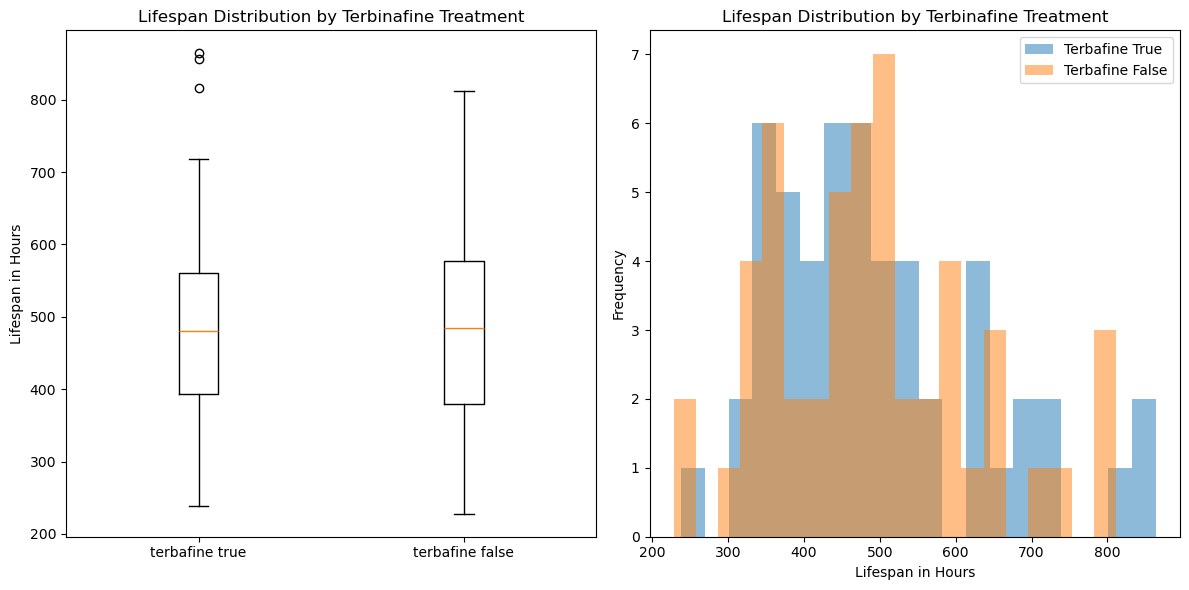

In [4]:
lifespan = {
    'terbafine true': summary[summary["Terbinafine"] == True]['LifespanInHours'],
    'terbafine false': summary[summary["Terbinafine"] == False]['LifespanInHours']
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.boxplot(lifespan.values(), tick_labels=lifespan.keys())
ax1.set_title('Lifespan Distribution by Terbinafine Treatment')
ax1.set_ylabel('Lifespan in Hours')

ax2.hist(lifespan['terbafine true'], bins=20, alpha=0.5, label='Terbafine True')
ax2.hist(lifespan['terbafine false'], bins=20, alpha=0.5, label='Terbafine False')
ax2.set_title('Lifespan Distribution by Terbinafine Treatment')
ax2.set_xlabel('Lifespan in Hours')
ax2.set_ylabel('Frequency')
ax2.legend()
plt.tight_layout()
plt.show()

In [5]:
# compare the summary LifespanInFrames with the number of frames in the corresponding files
import os
def count_frames_in_file(filepath):
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    with open(filepath, 'r') as f:
        lines = f.readlines()
    return len(lines) - 1  # assuming first line is header
summary['ManualFrameCount'] = summary['filepath'].apply(count_frames_in_file)
display(summary[['Filename', 'LifespanInFrames', 'ManualFrameCount']].head())

,Filename,LifespanInFrames,ManualFrameCount
0,/20240924_piworm09_1,49500,54000
1,/20240924_piworm09_2,63000,64800
2,/20240924_piworm09_3,57600,64800
3,/20240924_piworm09_4,50400,54000
4,/20240924_piworm09_5,48900,64800


array([ 54000,  64800,  75600,  43200,  86400,  98686,  97200, 108000,
       121852,  74985, 100185, 129600, 129543, 129489])

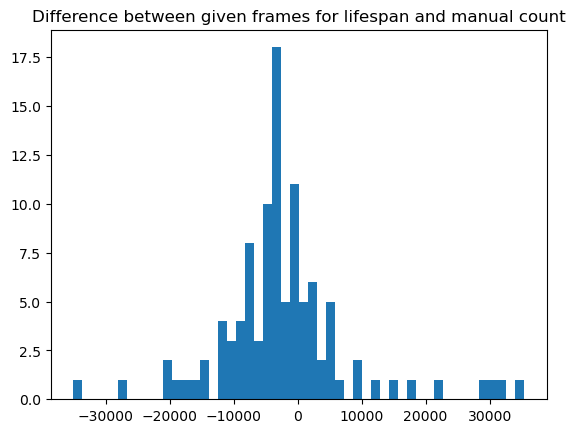

In [6]:
display(summary["ManualFrameCount"].unique())
plt.hist(summary["LifespanInFrames"] - summary["ManualFrameCount"], bins=50)
plt.title("Difference between given frames for lifespan and manual count")
plt.show()

***
## One sample analysis

In [7]:
sample_row = summary[summary["Terbinafine"] == False].iloc[1] # summary.iloc[(summary["LifespanInFrames"] - summary["ManualFrameCount"]).abs().idxmax()]
frame_of_death = sample_row["LifespanInFrames"]

In [8]:
# Load the data
sample = pd.read_csv(sample_row["filepath"], index_col="GlobalFrame").iloc[2:]
sample['Timestamp'] = pd.to_datetime(sample['Timestamp'])
sample['Timestamp'] = sample['Timestamp'].astype(np.int64) // 10**9  # Convert to seconds since epoch
sample['relative_time'] = sample['Timestamp'] - sample['Timestamp'].iloc[1]
sample.head()

,Timestamp,Speed,Fragment,LocalFrame,X,Y,relative_time
GlobalFrame,,,,,,,
3,1727192214,1.484716,worm_fragment_0_12,2,231.278689,239.983607,-2
4,1727192216,0.327050,worm_fragment_0_12,3,231.122034,240.030508,0
5,1727192218,0.538428,worm_fragment_0_12,4,231.232323,240.276094,2
6,1727192220,0.942767,worm_fragment_0_12,5,231.285256,239.807692,4
7,1727192222,0.229229,worm_fragment_0_12,6,231.304762,239.920635,6


In [9]:
print(f"X: [{sample["X"].min():.02f}, {sample["X"].max():.02f}], mean: {sample["X"].mean():.02f}, std: {sample["X"].std():.02f}")
print(f"Y: [{sample["Y"].min():.02f}, {sample["Y"].max():.02f}], mean: {sample["Y"].mean():.02f}, std: {sample["Y"].std():.02f}")

X: [114.83, 685.74], mean: 428.52, std: 99.38
Y: [0.00, 668.45], mean: 321.60, std: 118.69


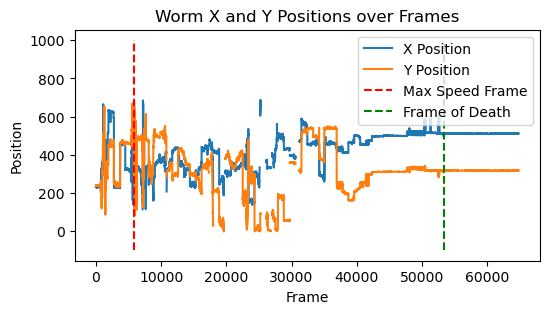

In [10]:
# Plot X and Y positions over time
plt.figure(figsize=(6, 3))
plt.plot(sample.index, sample["X"], label='X Position')
plt.plot(sample.index, sample["Y"], label='Y Position')
plt.vlines(sample.index[sample["Speed"].idxmax()], -100, 1000, color='r', linestyle='--', label='Max Speed Frame')
plt.vlines(frame_of_death, -100, 1000, color='g', linestyle='--', label='Frame of Death')
plt.title("Worm X and Y Positions over Frames")
plt.xlabel("Frame")
plt.ylabel("Position")
plt.legend()

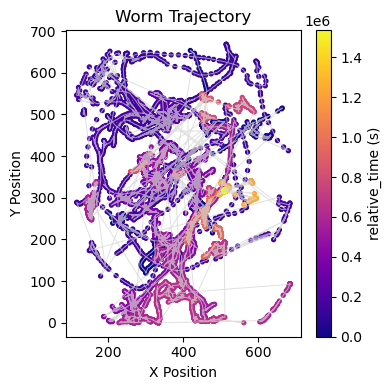

In [11]:
# Plot the trajectory of the worm colored by relative_time
df_traj = sample[['X', 'Y', 'relative_time']].dropna().sort_values('relative_time')

plt.figure(figsize=(4, 4))
plt.plot(df_traj['X'], df_traj['Y'], color='lightgray', linewidth=0.7, alpha=0.7)
sc = plt.scatter(df_traj['X'], df_traj['Y'], c=df_traj['relative_time'], cmap='plasma', s=8, marker='o')
cbar = plt.colorbar(sc)
cbar.set_label('relative_time (s)')
plt.title("Worm Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.tight_layout()
plt.show()

***
## Compare trajectories of 2 worms

In [12]:
def get_worm_trajectory(row):
    try:
        df = pd.read_csv(row["filepath"], index_col="GlobalFrame")
        df = df.iloc[2:] # Skip first 2 rows
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp_s'] = df['Timestamp'].astype(np.int64) // 10**9
        df['relative_time'] = df['Timestamp_s'] - df['Timestamp_s'].min() # Relative time from start, in seconds
        return df
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")
        return None

def plot_traj(ax, df, title):
    sc = ax.scatter(df['X'], df['Y'], c=df['relative_time'], cmap='plasma', s=5, alpha=0.6)
    ax.plot(df['X'], df['Y'], "--", color='lightgray', linewidth=0.7, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis('equal') # Important for trajectories
    return sc

def plot_time_series(ax, df, title, frame_of_death):
    ax.plot(df.index, df['X'], label='X Position')
    ax.plot(df.index, df['Y'], label='Y Position')
    ax.plot(df.index, df['Speed'], label='Speed', alpha=0.7)
    ax.vlines(frame_of_death, -100, 1000, color='g', linestyle='--', label='Frame of Death')
    ax.set_title(title)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Position")
    ax.legend()

In [13]:
def plot_trajectory_comparison(df_control, worm_control, df_terb, worm_terb):
    _, axes = plt.subplots(1, 2, figsize=(14, 6))
    sc1 = plot_traj(axes[0], df_control, f"Control (Lifespan: {worm_control['LifespanInHours']:.1f}h)")
    plt.colorbar(sc1, ax=axes[0], label='Time (s)')

    sc2 = plot_traj(axes[1], df_terb, f"Terbinafine (Lifespan: {worm_terb['LifespanInHours']:.1f}h)")
    plt.colorbar(sc2, ax=axes[1], label='Time (s)')

    plt.suptitle("Comparison of Worm Trajectories")
    plt.tight_layout()
    plt.show()

def plot_time_series_comparison(df_control, worm_control, df_terb, worm_terb):
    _, axes = plt.subplots(2, 1, figsize=(14, 6))
    plot_time_series(axes[0], df_control, f"Control (Lifespan: {worm_control['LifespanInHours']:.1f}h)\n{'⚠️ Dried plate' if worm_control['PlateHasDried'] else 'Healthy plate'}",
                     worm_control["LifespanInFrames"])
    plot_time_series(axes[1], df_terb, f"Terbinafine (Lifespan: {worm_terb['LifespanInHours']:.1f}h)\n{'⚠️ Dried plate' if worm_terb['PlateHasDried'] else 'Healthy plate'}",
                     worm_terb["LifespanInFrames"])

    plt.suptitle("Comparison of Worm X and Y Positions over Frames")
    plt.tight_layout()
    plt.show()

def plot_speed_around_death_comparison(df_control, worm_control, df_terb, worm_terb, window=20):
    fc = int(worm_control["LifespanInFrames"])
    ft = int(worm_terb["LifespanInFrames"])

    s_control = df_control["Speed"].loc[fc - window: fc + window]
    s_terb = df_terb["Speed"].loc[ft - window: ft + window]

    # convert index to frames relative to death
    x_control = s_control.index - fc
    x_terb = s_terb.index - ft

    plt.figure(figsize=(8, 3))
    if not s_control.empty:
        plt.plot(x_control, s_control, marker='o', label=f'Control (frame={fc})', color='C0')
    
    if not s_terb.empty:
        plt.plot(x_terb, s_terb, marker='o', label=f'Terbinafine (frame={ft})', color='C1')

    plt.axvline(0, color='k', linestyle='--', label='Death frame')
    plt.xlabel('Frame relative to death (0 = death)')
    plt.ylabel('Speed')
    plt.title(f'Speed around death (±{window} frames)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

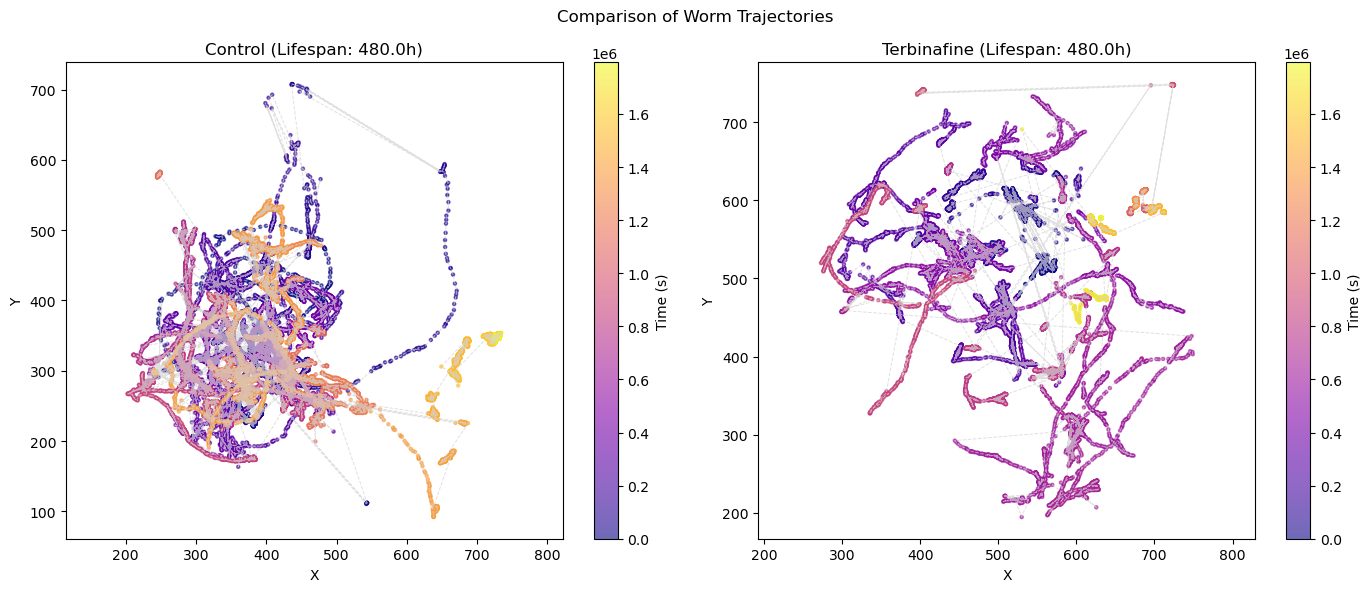

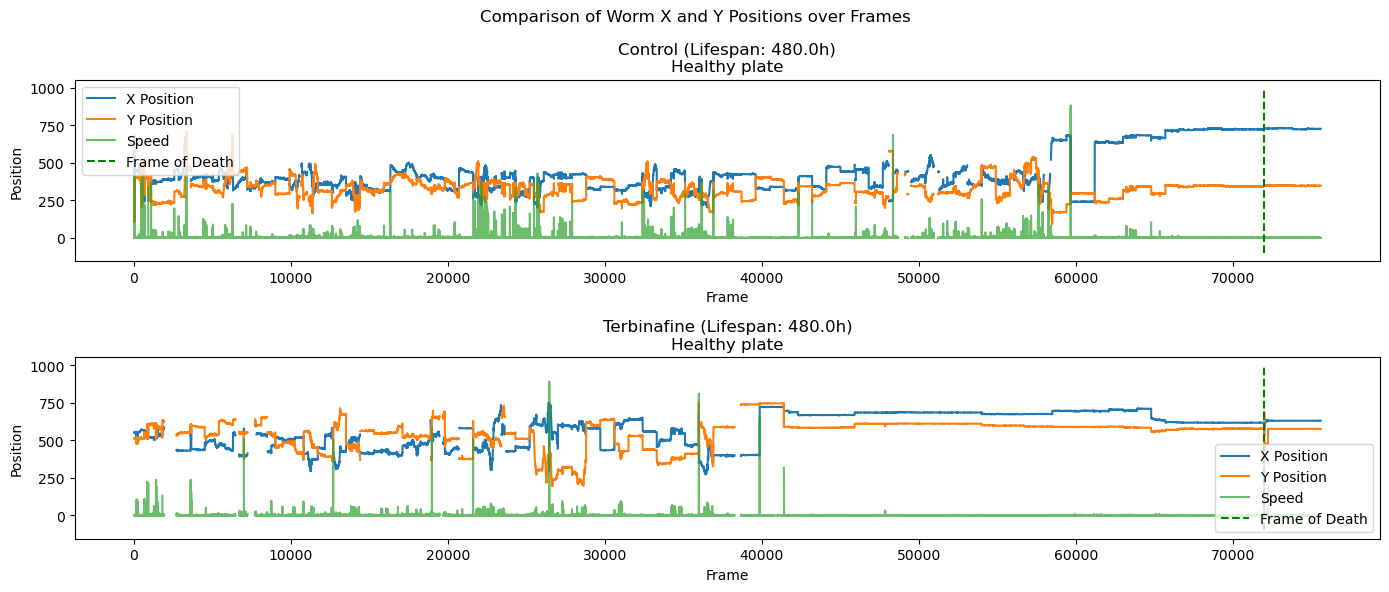

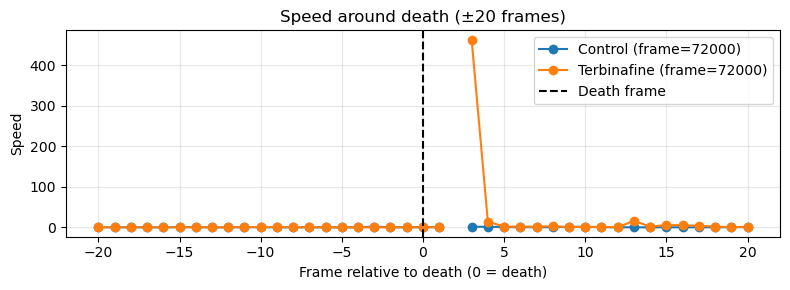

In [14]:
worm_control = summary[summary["Terbinafine"] == False].iloc[10]
worm_terb = summary[summary["Terbinafine"] == True].iloc[10]

df_control = get_worm_trajectory(worm_control)
df_terb = get_worm_trajectory(worm_terb)

plot_trajectory_comparison(df_control, worm_control, df_terb, worm_terb)
plot_time_series_comparison(df_control, worm_control, df_terb, worm_terb)
plot_speed_around_death_comparison(df_control, worm_control, df_terb, worm_terb)